In [25]:
import wandb
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd

api = wandb.Api(timeout=39)

# Define your project and entity (replace with your specific values)
entity = "wang-kevin3290-princeton-university"  # e.g., your username or team name
project = "clean_JaxGCRL_test"


# Make all font sizes big for title, axes labels, axes ticks, and legend.
mpl.rcParams['figure.dpi'] = 150                # optionally increase figure resolution
mpl.rcParams['axes.titlesize'] = 20            # title font size
mpl.rcParams['axes.labelsize'] = 14           # x and y labels font size
mpl.rcParams['xtick.labelsize'] = 14           # x tick labels font size
mpl.rcParams['ytick.labelsize'] = 14           # y tick labels font size
mpl.rcParams['legend.fontsize'] = 12         # legend entries font size

In [26]:
env_id = "arm_binpick_hard"
eval_env_id = None #"ant_u5_maze_eval"
env_title = "Arm Binpick Hard"
num_epochs = 100
metric = 'eval/episode_success'
metric_label = "Success"
valid_depths = [4, 8, 16, 32, 64]

filters = {
    "config.env_id": env_id,
    "config.eval_env_id": eval_env_id if eval_env_id else {"$in": ['', None, env_id]}, #{"$ne": "xxx"}, #
    "config.num_envs": 512,
    "config.num_sgd_batches_per_training_step": 800,
    "config.critic_network_width": 256,
    "config.batch_size": 512,
    "config.num_epochs": {"$in": [num_epochs]}, #num_epochs,
    "config.disable_entropy": {"$ne": 1},
    "config.use_relu": {"$ne": 1},
    "config.resnet": "noishmistake4_nodense",
    "config.dropout": None,
    "config.logsumexp_penalty_coeff": {"$in": [None, 0.1]},
}

runs_api = api.runs(path=f"{entity}/{project}", filters=filters) #runs filtered by wandb api
len(runs_api)

169

In [27]:
#local filters
runs = []
dfs = {} #scratch space for arm_binpick_easy


for run in runs_api:
    # check it actually has num_epoch steps completed
    if '_step' not in run.summary.keys():
        continue
    if run.summary['_step'] != run.config['num_epochs'] - 1:
        continue

    #check actor_depth == critic_depth and filter for valid_depths
    actor_depth = run.config['actor_depth']
    critic_depth = run.config['critic_depth']

    if actor_depth != critic_depth:
        continue
    if actor_depth not in valid_depths:
        continue

    runs.append(run)
len(runs)

30

In [28]:
depth_count = collections.defaultdict(int)
for run in runs:
    # print(f"{run.config['actor_depth']}: {run.config['seed']}")
    depth_count[run.config['actor_depth']] += 1

for d, c in depth_count.items():
    print(f"{d}: {c}")

4: 7
8: 6
16: 5
32: 6
64: 6


In [29]:
# Gather the raw metric curves by depth
depth_curves = collections.defaultdict(list) #{d: [] for d in valid_depths}, where it's a list of lists

for run in runs:
    depth = run.config['actor_depth']
    # Pull the full training history from W&B
    hist = run.history()
    if metric not in hist.columns:
        print("WARNING: metric not found in hist.columns for depth {depth} seed {run.config['seed']}, continuing...")
        continue
    values = hist[metric].values  # shape = (num_epochs,)
    depth_curves[depth].append(values)

print(f"completed part 1")

# Now, for each depth, compute mean/std
depth_mean = collections.defaultdict(list) #d -> curve (mean)
depth_std = collections.defaultdict(list) # d -> std
for depth in valid_depths:
    curves = depth_curves[depth]
    print(f"{len(curves)} curves for depth {depth}")
    
    # Stack all runs for this depth: shape = (num_runs, num_epochs)
    arr = np.stack(curves, axis=0)  # e.g. (N_runs, 100)
    mean_curve = arr.mean(axis=0)
    std_curve  = arr.std(axis=0) / np.sqrt(len(curves))
    assert len(curves) == arr.shape[0]
    depth_mean[depth] = mean_curve
    depth_std[depth] = std_curve

completed part 1
7 curves for depth 4
6 curves for depth 8
5 curves for depth 16
6 curves for depth 32
6 curves for depth 64


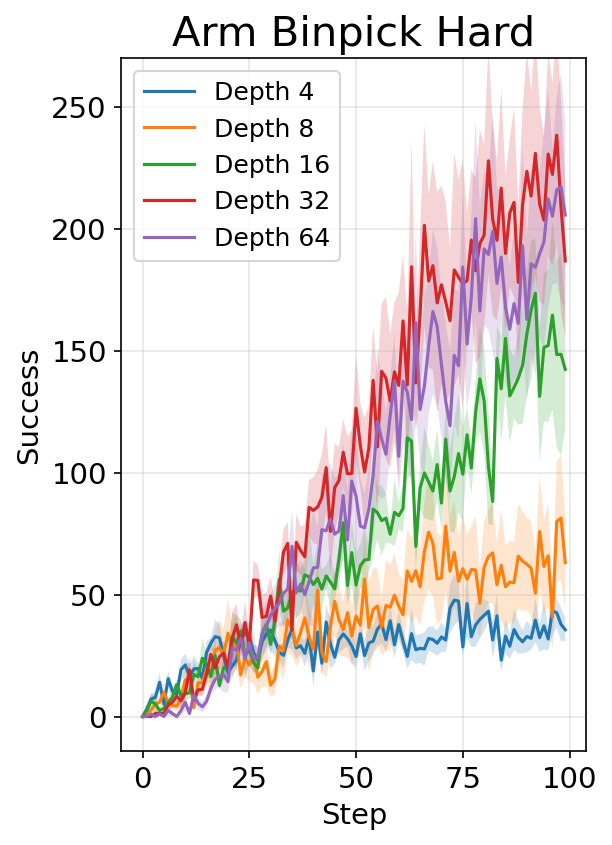

In [33]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.ylim(top=270)  # Changed from percentage to fraction
# plt.ylim(bottom=50)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

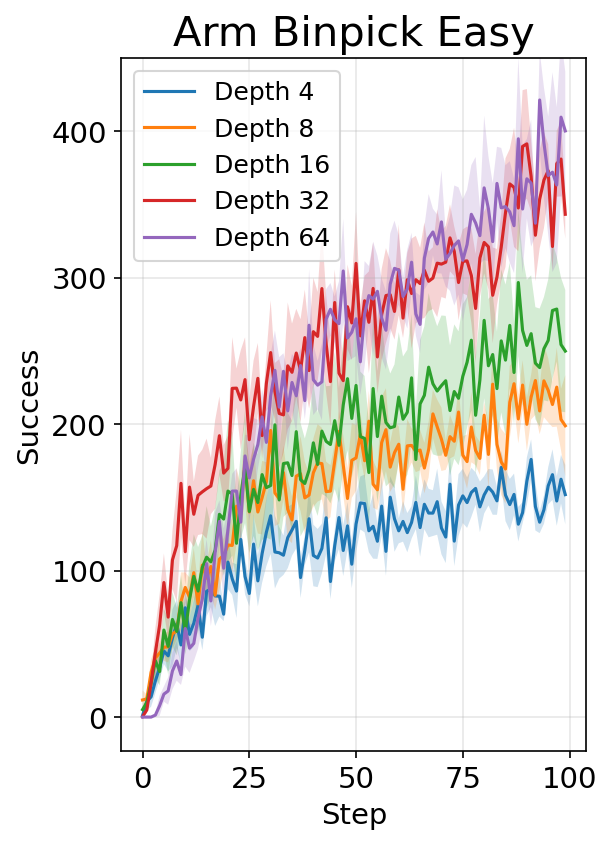

In [24]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.ylim(top=450)  # Changed from percentage to fraction
# plt.ylim(bottom=50)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

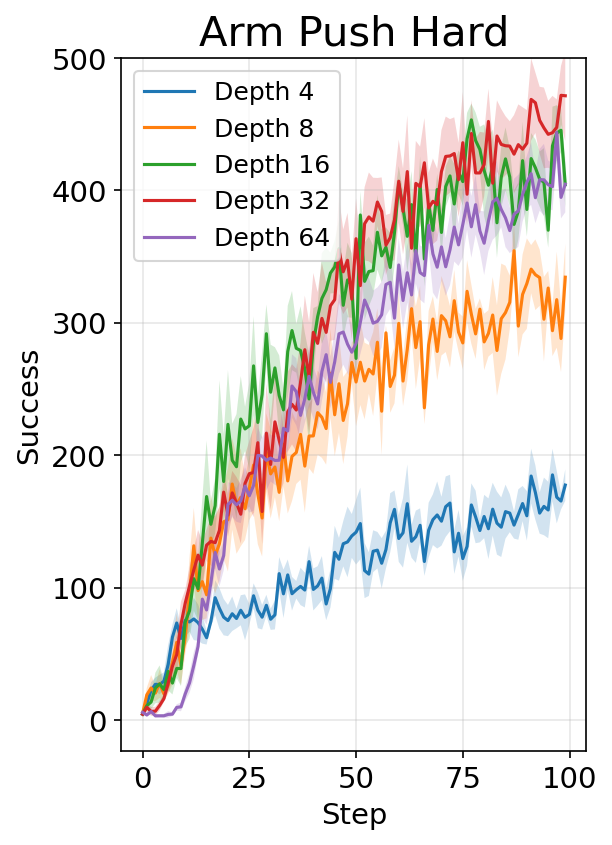

In [13]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)
plt.ylim(top=500)  # Changed from percentage to fraction
# plt.ylim(bottom=100)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

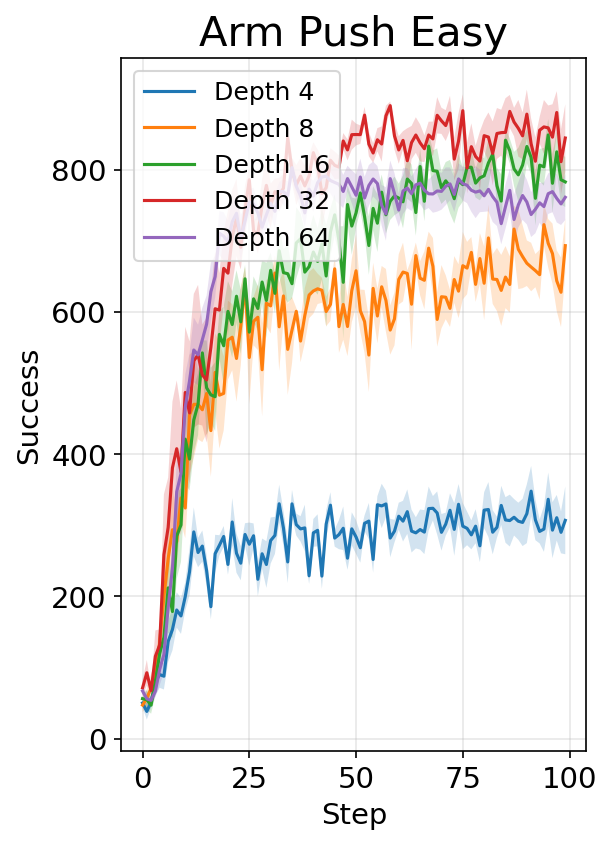

In [132]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)
# plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
# plt.ylim(bottom=100)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

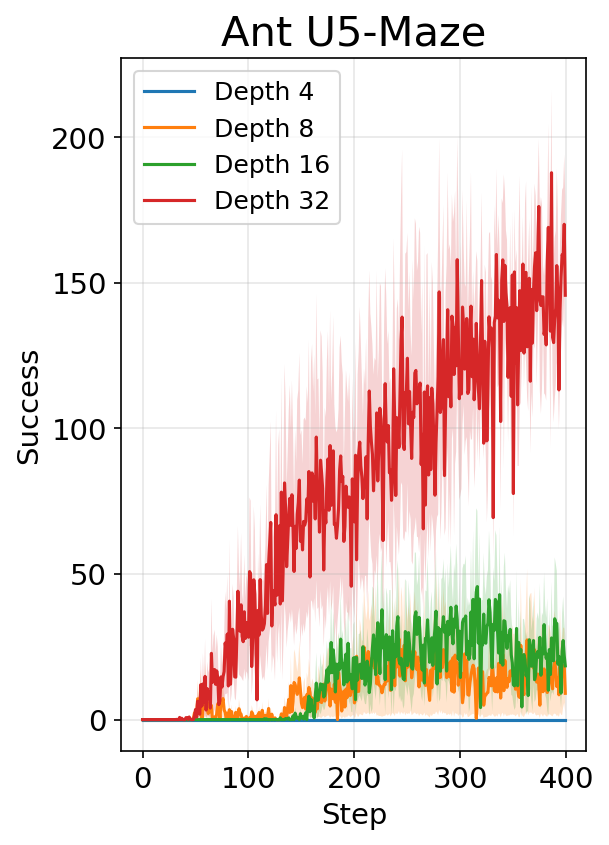

In [125]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths[:-1]:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)
# plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
# plt.ylim(bottom=100)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

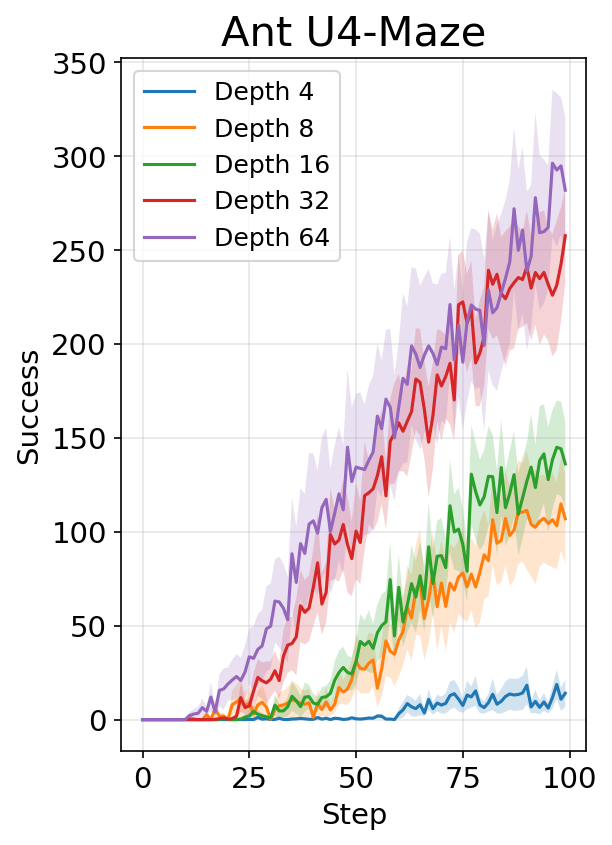

In [111]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)
# plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
# plt.ylim(bottom=100)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

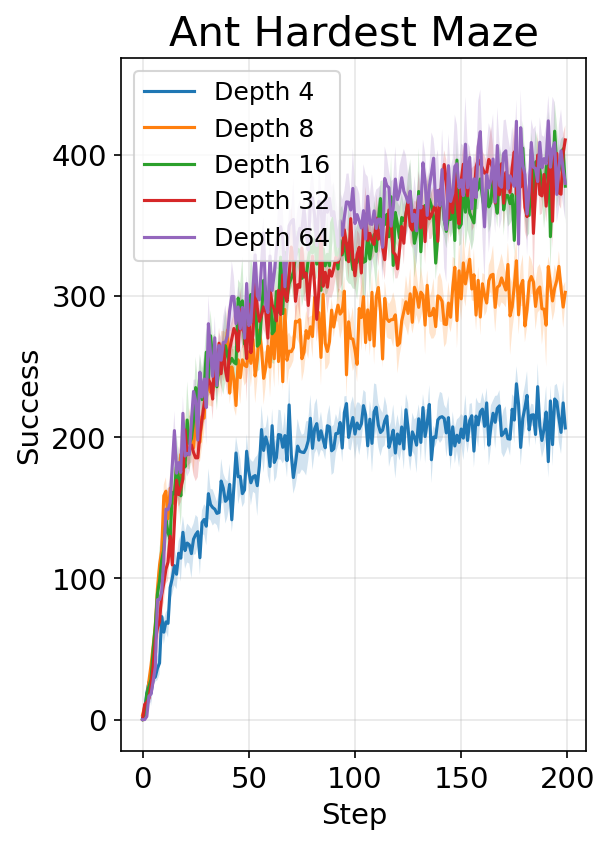

In [105]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)
# plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
# plt.ylim(bottom=100)  # Changed from percentage to fraction
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

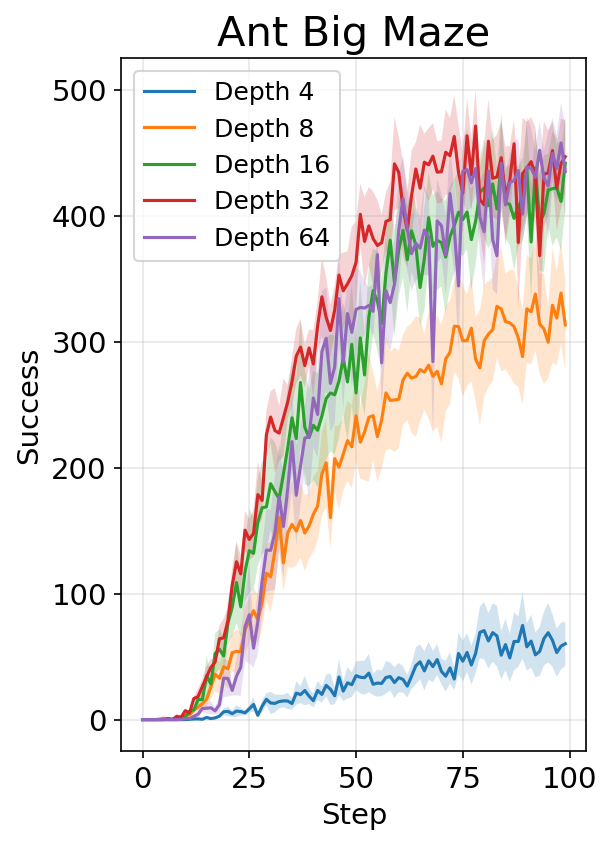

In [80]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
# plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

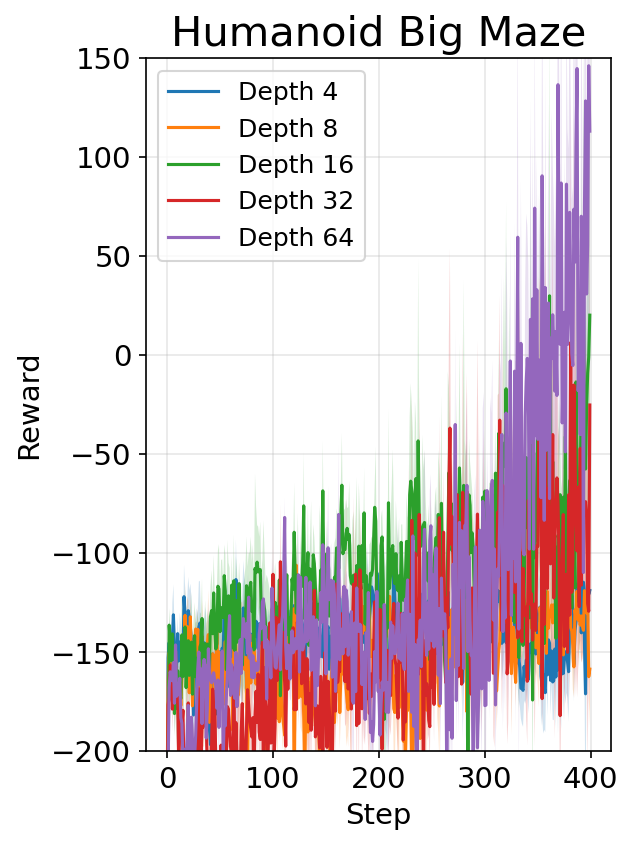

In [73]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.ylim(bottom=-200, top=150)  # Changed from percentage to fraction
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

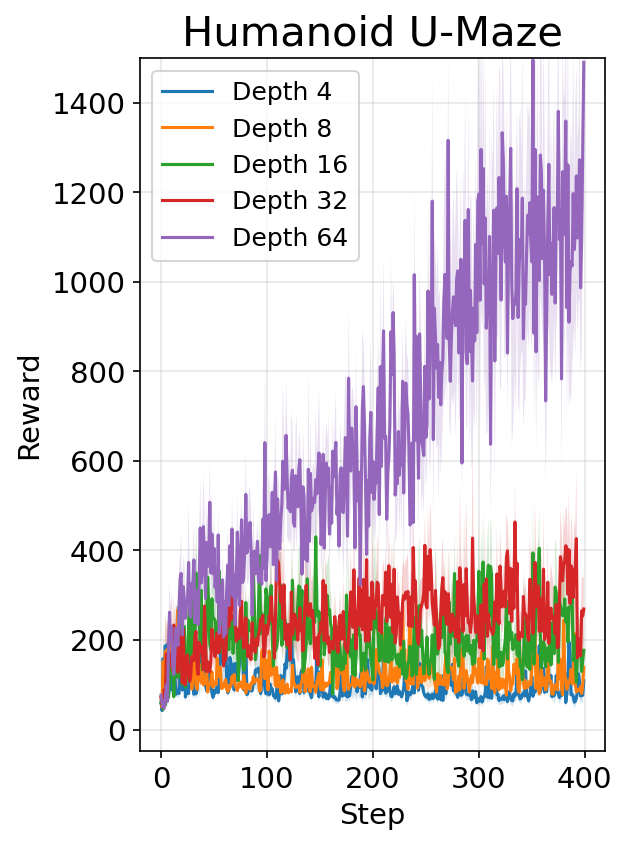

In [33]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.ylim(top=1500)  # Changed from percentage to fraction
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

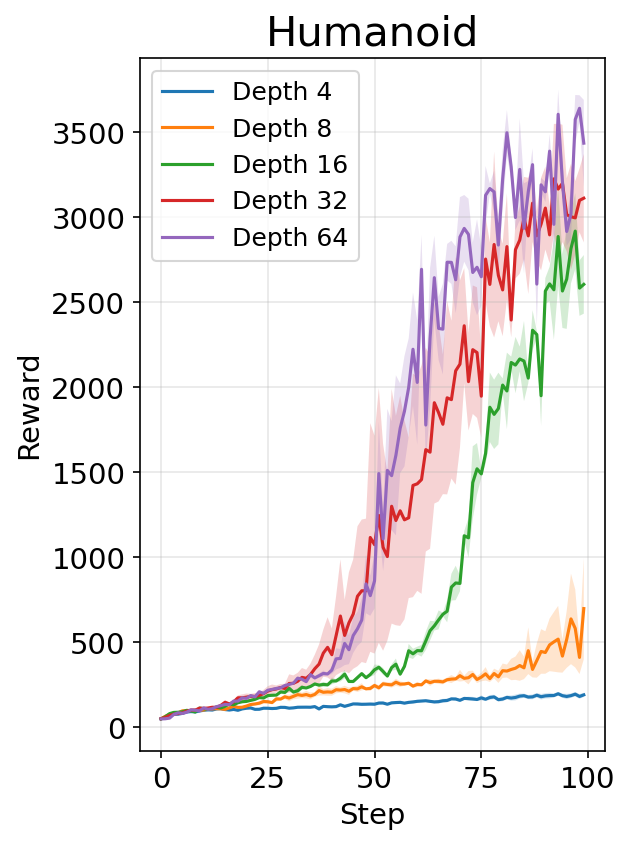

In [25]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

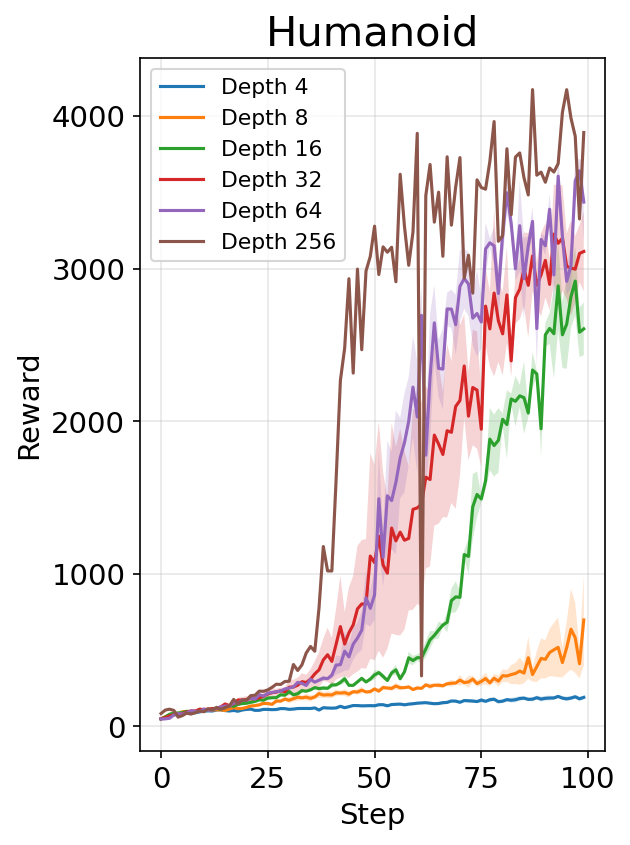

In [46]:
plt.figure(figsize=(4,6))

# Plot mean ± std
for depth in valid_depths:
    mean_curve, std_curve = depth_mean[depth], depth_std[depth]
    plt.fill_between(range(num_epochs), mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.plot(range(num_epochs), mean_curve, label=f"Depth {depth}")

plt.title(f"{env_title}")
plt.xlabel("Step")
plt.ylabel(metric_label)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
depth_perf = collections.defaultdict(list)
postfix = 5 #we want the average of the last 5 values
for run in runs:
    depth = run.config['actor_depth']
    history = run.history()[metric]
    assert len(history) == run.config['num_epochs']
    perf = np.mean(history.values[-postfix:])
    depth_perf[depth].append(perf)
depth_perf = dict(sorted(depth_perf.items()))
depth_means = [np.mean(depth_perf[depth]) for depth in depth_perf.keys()]
depth_stds = [np.std(depth_perf[depth]) for depth in depth_perf.keys()]

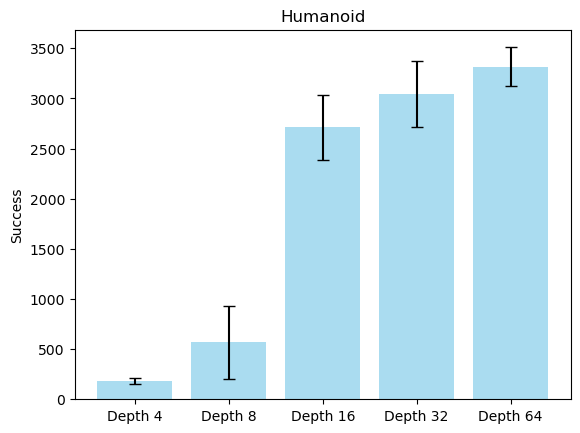

In [11]:
depths = list(depth_perf.keys())

plt.figure()
plt.bar(range(len(depths)), depth_means, yerr=depth_stds, capsize=4, alpha=0.7, color='skyblue')
plt.xticks(range(len(depths)), [f"Depth {d}" for d in depths])
plt.title(env_title)
plt.ylabel("Success")
plt.show()

In [69]:
import wandb
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd

api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "wang-kevin3290-princeton-university"  # e.g., your username or team name
project = "clean_JaxGCRL_test"


# env_type = "Humanoid" 
# env_type = "AntMaze"
# env_type = "ArmManipulation"
env_type = "ALL"

if env_type == "Humanoid":
    env_ids = ["humanoid", "humanoid_u_maze", "humanoid_big_maze"]
    eval_env_ids = [None, None, None]
    env_titles = ["Humanoid", "Humanoid U-Maze", "Humanoid Big Maze"]
    num_epochss = [200, 400, 200]
    num_envs = len(env_ids)
    metrics = ['eval/episode_reward', 'eval/episode_reward', 'eval/episode_success_any']
    aggregated_title = "Humanoid (3 Tasks)"
elif env_type == "AntMaze":
    env_ids = ["ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze"]
    eval_env_ids = ["ant_big_maze_eval", None, "ant_u4_maze_eval", None] #"ant_u4_maze_eval"
    env_titles = ["Ant Big Maze", "Ant Hardest Maze", "Ant U4-Maze", "Ant U5-Maze"]
    num_epochss = [100, 200, 100, 200]
    metrics = ['eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any']
    num_envs = len(env_ids)
    aggregated_title = "AntMaze (4 Tasks)"
elif env_type == "ArmManipulation":
    # env_ids = ["arm_push_easy", "arm_push_hard", "arm_binpick_easy", "arm_binpick_hard"]
    # eval_env_ids = [None, None, None, None] #"ant_u4_maze_eval"
    # env_titles = ["Arm Push Easy", "Arm Push Hard", "Arm Binpick Easy", "Arm Binpick Hard"]
    # num_epochss = [100, 100, 100, 100]
    # metrics = ['eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard']
    # num_envs = len(env_ids)
    # aggregated_title = "ArmManipulation (4 Tasks)"
    env_ids = ["arm_push_easy", "arm_push_hard", "arm_binpick_hard"]
    eval_env_ids = [None, None, None] #"ant_u4_maze_eval"
    env_titles = ["Arm Push Easy", "Arm Push Hard", "Arm Binpick Hard"]
    num_epochss = [100, 100, 100]
    metrics = ['eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard']
    num_envs = len(env_ids)
    aggregated_title = "ArmManipulation (3 Tasks)"
elif env_type == "ALL":
    # env_ids = ["humanoid", "humanoid_u_maze", "humanoid_big_maze", "ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze", "arm_push_easy", "arm_push_hard", "arm_binpick_easy", "arm_binpick_hard"]
    # eval_env_ids = [None, None, None, "ant_big_maze_eval", None, "ant_u4_maze_eval", None, None, None, None, None]
    # env_titles = ["Humanoid", "Humanoid U-Maze", "Humanoid Big Maze", "Ant Big Maze", "Ant Hardest Maze", "Ant U4-Maze", "Ant U5-Maze", "Arm Push Easy", "Arm Push Hard", "Arm Binpick Easy", "Arm Binpick Hard"]
    # num_epochss = [200, 400, 200, 100, 200, 100, 200, 100, 100, 100, 100]
    # metrics = ['eval/episode_reward', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard']
    # num_envs = len(env_ids)
    # aggregated_title = "Aggregated Normalized Performance (11 Tasks)"
    env_ids = ["humanoid", "humanoid_u_maze", "humanoid_big_maze", "ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze", "arm_push_easy", "arm_push_hard", "arm_binpick_hard"]
    eval_env_ids = [None, None, None, "ant_big_maze_eval", None, "ant_u4_maze_eval", None, None, None, None]
    env_titles = ["Humanoid", "Humanoid U-Maze", "Humanoid Big Maze", "Ant Big Maze", "Ant Hardest Maze", "Ant U4-Maze", "Ant U5-Maze", "Arm Push Easy", "Arm Push Hard", "Arm Binpick Hard"]
    num_epochss = [200, 400, 200, 100, 200, 100, 200, 100, 100, 100]
    metrics = ['eval/episode_reward', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_any', 'eval/episode_success_hard', 'eval/episode_success_hard', 'eval/episode_success_hard']
    num_envs = len(env_ids)
    aggregated_title = "Aggregated Normalized Performance (10 Tasks)"


10
Env: humanoid: Wandb API found 75 runs
Env: humanoid: Local filters further filtered to 28 runs
depth_perf: {4: [263.60083923339846, 195.02874755859375, 266.5758850097656, 279.158203125, 240.88528442382812, 223.63743896484374, 277.1420959472656, 260.10609130859376], 8: [3027.231494140625, 3091.065576171875, 2359.507080078125, 2990.728662109375, 2891.840673828125], 16: [3248.091748046875, 3730.47900390625, 3481.9466796875, 3420.96953125, 3614.6693359375], 32: [3830.739111328125, 3926.225537109375, 3948.82421875, 3914.793212890625, 3903.2064453125], 64: [3889.42646484375, 3677.8224609375, 3884.13720703125, 3694.127197265625, 3831.996435546875]}
norm_scale: 4325.8994140625
Env: humanoid_u_maze: Wandb API found 50 runs
Env: humanoid_u_maze: Local filters further filtered to 25 runs
depth_perf: {4: [0.0, 0.1875, 0.1375, 0.1890625, 0.0], 8: [0.1359375, 0.153125, 0.165625, 0.1390625, 0.1734375], 16: [0.1828125, 0.16875, 0.409375, 0.178125, 0.1875], 32: [0.3265625, 0.1671875, 0.3953125, 0.1

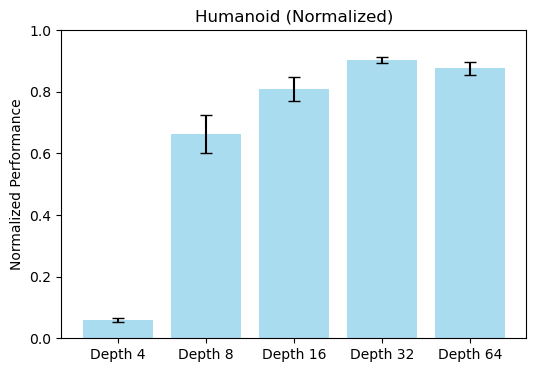

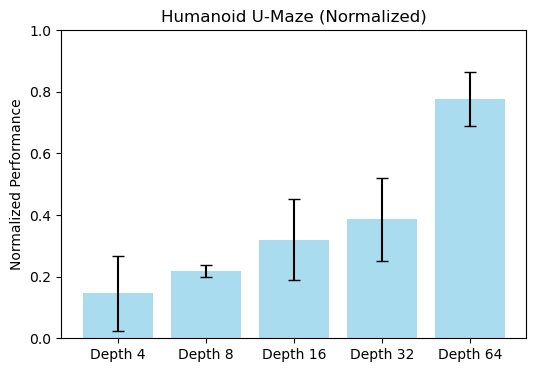

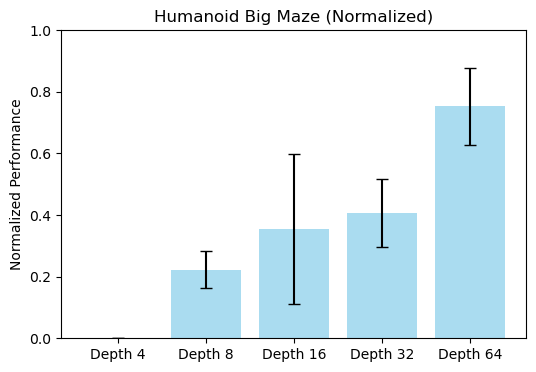

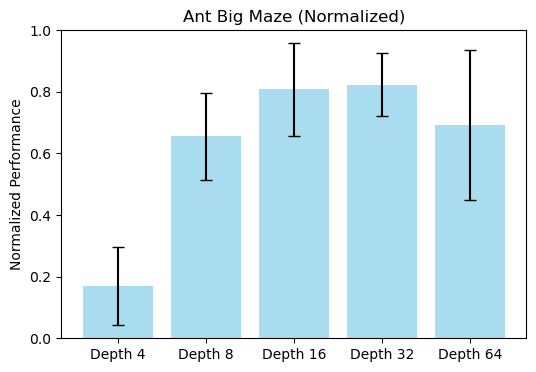

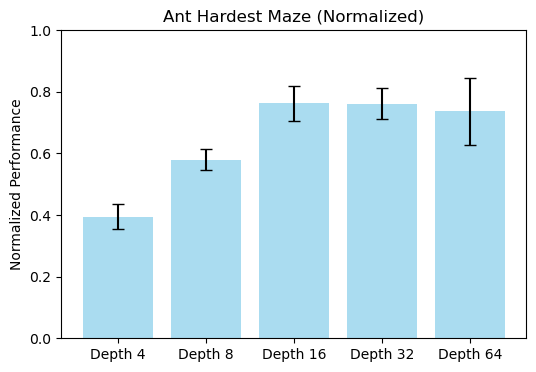

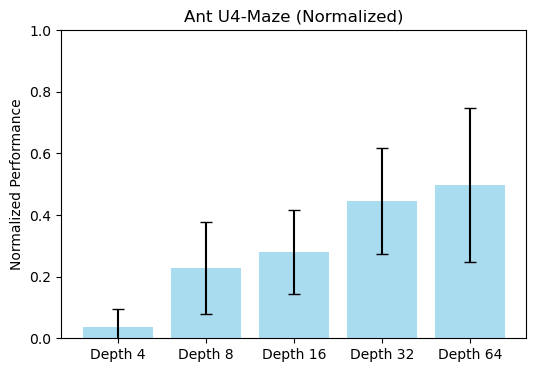

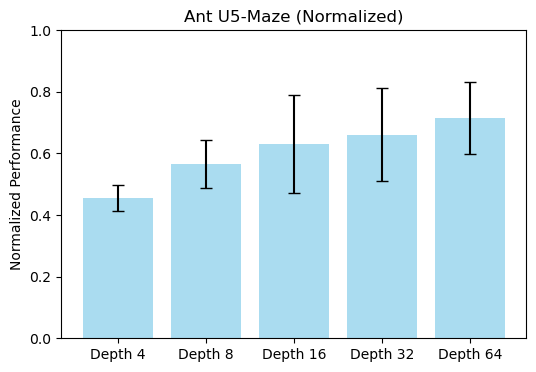

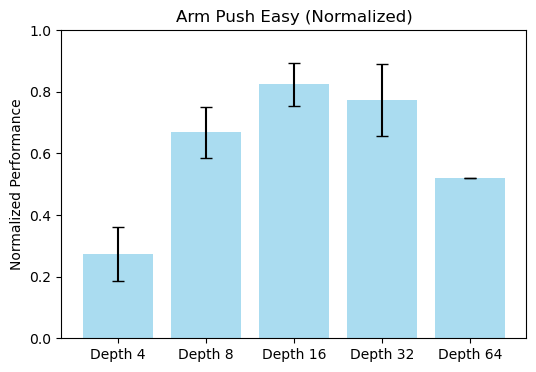

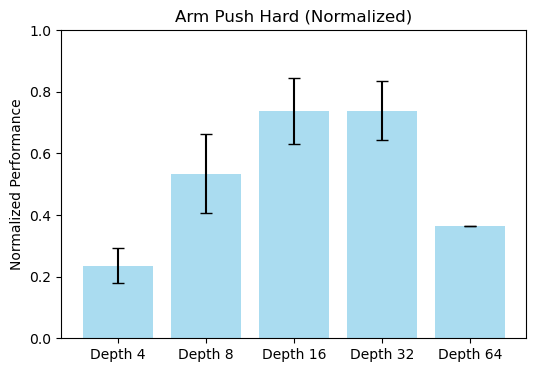

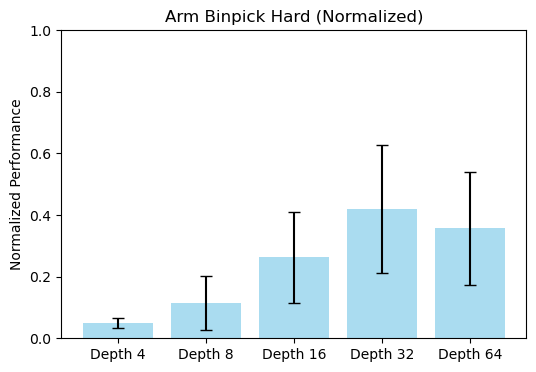

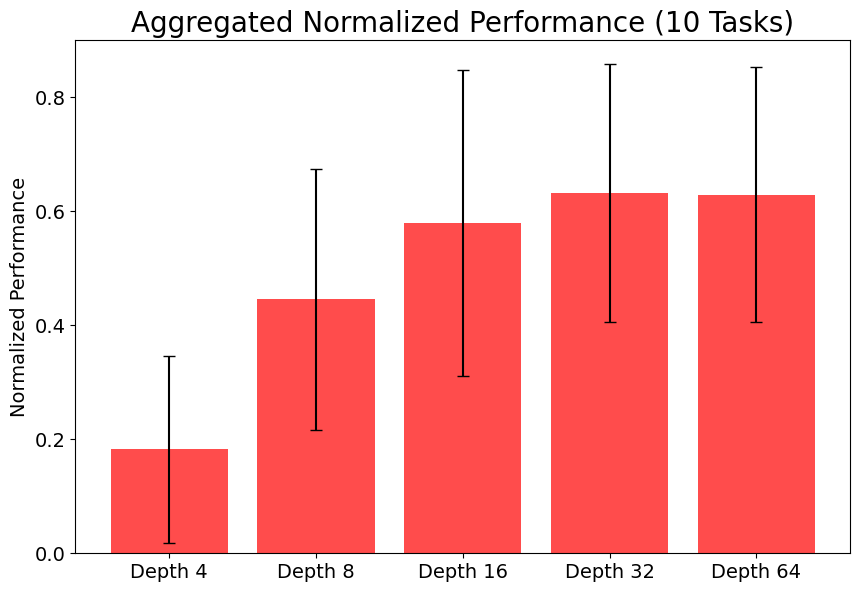

In [70]:
num_envs = len(env_ids)
print(num_envs)
env_stats = []
for i in range(num_envs):
    env_id = env_ids[i]
    eval_env_id = eval_env_ids[i]
    env_title = env_titles[i]
    num_epochs = num_epochss[i]
    metric = metrics[i]

    filters = {
        "config.env_id": env_id,
        "config.num_envs": 512,
        "config.num_sgd_batches_per_training_step": 800,
        "config.critic_network_width": 256,
        "config.actor_network_width": 256,
        "config.batch_size": 512,
        "config.num_epochs": num_epochs, #{"$in": [num_epochs, num_epochs-1, num_epochs-2]}, 
        "config.eval_env_id": eval_env_id if eval_env_id else {"$in": ['', None, env_id]}, #{"$ne": "xxx"}, #
        "config.disable_entropy": {"$ne": 1},
        "config.use_relu": {"$ne": 1},
        "config.resnet": "noishmistake4_nodense",
        "config.dropout": None,
        "config.logsumexp_penalty_coeff": 0.1,
    }
    
    runs_api = api.runs(path=f"{entity}/{project}", filters=filters) #runs filtered by wandb api
    print(f"Env: {env_id}: Wandb API found {len(runs_api)} runs")

    #local filters
    runs = []
    
    valid_depths = [4, 8, 16, 32, 64]
    for run in runs_api:
        assert 'dropout' not in run.config
        #check it actually has num_epoch steps completed
        # if 'arm' not in run.config['env_id']:
        if '_step' not in run.summary.keys():
            continue
        if run.summary['_step'] != run.config['num_epochs'] - 1:
            continue
    
        #check actor_depth == critic_depth and filter for valid_depths
        actor_depth = run.config['actor_depth']
        critic_depth = run.config['critic_depth']
        if actor_depth != critic_depth:
            continue
        if actor_depth not in valid_depths:
            continue
    
        runs.append(run)
    print(f"Env: {env_id}: Local filters further filtered to {len(runs)} runs")

    depth_perf = collections.defaultdict(list)
    postfix = 5 #we want the average of the last 5 values
    max_val = float('-inf')
    for run in runs:
        depth = run.config['actor_depth']
        history = run.history()[metric] #run.history(keys=[metric])[metric]
        assert len(history) == run.config['num_epochs']
        perf = np.mean(history.values[-postfix:])
        max_val = max(max_val, np.max(history.values[-postfix:]))
        depth_perf[depth].append(perf)
    depth_perf = dict(sorted(depth_perf.items())) #results in {4: [run1, run2, run3, run4], 8: [run1, run2], ... 64: [run1, run2, run3]}
    depth_means = [np.mean(depth_perf[depth]) for depth in depth_perf.keys()]
    depth_stds = [np.std(depth_perf[depth]) for depth in depth_perf.keys()]

    #Let's normalize performance to 0-1 scale by dividing by the max performance? But this max must be out of ALL RUNS, ACROSS ALL DEPTHS,
    #AND WE ARE ACTUALLY GOING TO ACROSS THE 5 POSTFIX too (so errorbar guaranteed not to OOB) So we add that, and 
    #then UPDATE THE MEANS and STDS
    print(f"depth_perf: {depth_perf}")
    norm_scale = max_val
    print(f"norm_scale: {norm_scale}")
    depth_means = [mean / norm_scale for mean in depth_means]
    depth_stds = [std / norm_scale for std in depth_stds]

    env_stats.append(
        {
            "env_id": env_id,
            "env_title": env_title,
            "metric": metric,
            "depths": list(depth_perf.keys()),
            "means": depth_means,
            "stds": depth_stds,
        }
    )

for env_stat in env_stats:
    depths = env_stat["depths"]
    means = env_stat["means"]
    stds = env_stat["stds"]
    title = env_stat['env_title']
    
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(depths)), means, yerr=stds, capsize=4, alpha=0.7, color='skyblue')
    plt.xticks(range(len(depths)), [f"Depth {d}" for d in depths])
    plt.title(f"{title} (Normalized)")
    plt.ylabel("Normalized Performance")
    plt.ylim([0, 1])
    plt.show()

#Aggregate_stats
means_aggregated = []
stds_aggregated = []

for i in range(len(depths)):
    depth = depths[i]
    aggregated_mean = np.mean([env_stat['means'][i] for env_stat in env_stats])
    #aggregated variance is the avg variance + difference from overall mean squared
    aggregated_variance = np.mean([env_stat['stds'][i]**2 for env_stat in env_stats])
    aggregated_variance += np.mean([(env_stat['means'][i]-aggregated_mean)**2 for env_stat in env_stats])
    aggregated_std = aggregated_variance**0.5
    means_aggregated.append(aggregated_mean)
    stds_aggregated.append(aggregated_std)

#Plot aggregated
plt.figure(figsize=(10, 20/3))
plt.bar(range(len(depths)), means_aggregated, yerr=stds_aggregated, capsize=4, alpha=0.7, color='red')
plt.xticks(range(len(depths)), [f"Depth {d}" for d in depths], fontsize=14)
plt.title(aggregated_title, fontsize=20)
plt.ylabel("Normalized Performance", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(bottom=0)
plt.show()

In [15]:
print(means_aggregated)
print(stds_aggregated)

[0.1867061842647275, 0.43964620089206363, 0.6090211311479239, 0.6437069251199065, 0.41416713607260064]
[0.11588234582279437, 0.25629247501196234, 0.271577860505628, 0.21763590300487187, 0.13028748182378888]


Env: arm_push_easy: W&B API found 90 runs
Env: arm_push_easy: local filters -> 24 runs remain.
Env: arm_push_hard: W&B API found 70 runs
Env: arm_push_hard: local filters -> 26 runs remain.
Env: arm_binpick_hard: W&B API found 129 runs
Env: arm_binpick_hard: local filters -> 30 runs remain.


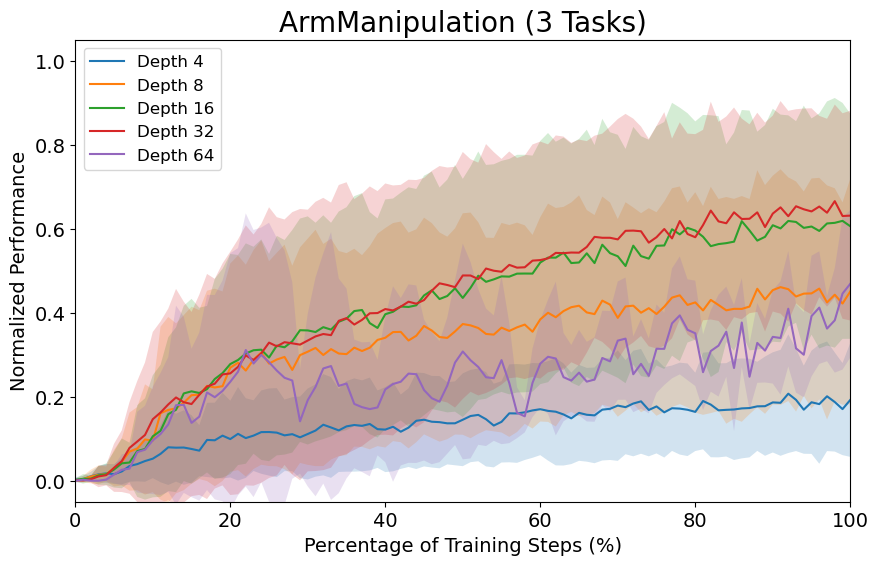

In [72]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

api = wandb.Api()

###############################################################################
# 1) Define your W&B project and environment selection
###############################################################################
entity = "wang-kevin3290-princeton-university"
project = "clean_JaxGCRL_test"

# env_type = "Humanoid"
# env_type = "AntMaze"
env_type = "ArmManipulation"
# env_type = "ALL"

if env_type == "Humanoid":
    env_ids = ["humanoid", "humanoid_u_maze", "humanoid_big_maze"]
    eval_env_ids = [None, None, None]
    num_epochss = [200, 400, 200]
    metrics = ["eval/episode_reward", "eval/episode_reward", "eval/episode_success_any"]
    aggregated_title = "Humanoid (3 Tasks)"

elif env_type == "AntMaze":
    env_ids = ["ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze"]
    eval_env_ids = ["ant_big_maze_eval", None, "ant_u4_maze_eval", None]
    num_epochss = [100, 200, 100, 200]
    metrics = ["eval/episode_success_any"] * 4
    aggregated_title = "AntMaze (4 Tasks)"

elif env_type == "ArmManipulation":
    env_ids = ["arm_push_easy", "arm_push_hard", "arm_binpick_hard"]
    eval_env_ids = [None, None, None]
    num_epochss = [100, 100, 100]
    metrics = ["eval/episode_success_hard"] * 3
    aggregated_title = "ArmManipulation (3 Tasks)"

elif env_type == "ALL":
    env_ids = [
        "humanoid", "humanoid_u_maze", "humanoid_big_maze",
        "ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze",
        "arm_push_easy", "arm_push_hard", "arm_binpick_hard"
    ]
    eval_env_ids = [
        None, None, None,
        "ant_big_maze_eval", None, "ant_u4_maze_eval", None,
        None, None, None
    ]
    num_epochss = [200, 400, 200, 100, 200, 100, 200, 100, 100, 100]
    metrics = [
        "eval/episode_reward", "eval/episode_success_any", "eval/episode_success_any",
        "eval/episode_success_any", "eval/episode_success_any", "eval/episode_success_any",
        "eval/episode_success_any", "eval/episode_success_hard",
        "eval/episode_success_hard", "eval/episode_success_hard"
    ]
    aggregated_title = "Aggregated Normalized Performance (10 Tasks)"

valid_depths = [4, 8, 16, 32, 64]

###############################################################################
# 2) Gather runs from W&B and store their metric curves
###############################################################################
# We'll store raw runs in: per_env_depth_runs[env_id][depth] = list of arrays
# Each array is shape (num_epochs,) with the metric at each epoch.
###############################################################################
per_env_depth_runs = {
    env_id: {depth: [] for depth in valid_depths} for env_id in env_ids
}
env_steps = {}

for i, env_id in enumerate(env_ids):
    eval_env_id = eval_env_ids[i]
    metric = metrics[i]
    num_epochs = num_epochss[i]
    env_steps[env_id] = num_epochs

    # W&B filters
    filters = {
        "config.env_id": env_id,
        "config.num_envs": 512,
        "config.num_sgd_batches_per_training_step": 800,
        "config.critic_network_width": 256,
        "config.actor_network_width": 256,
        "config.batch_size": 512,
        "config.num_epochs": num_epochs,
        "config.eval_env_id": eval_env_id if eval_env_id else {"$in": ['', None, env_id]},
        "config.disable_entropy": {"$ne": 1},
        "config.use_relu": {"$ne": 1},
        "config.resnet": "noishmistake4_nodense",
        "config.dropout": None,
        "config.logsumexp_penalty_coeff": 0.1,
    }

    runs_api = api.runs(path=f"{entity}/{project}", filters=filters)
    print(f"Env: {env_id}: W&B API found {len(runs_api)} runs")

    # Additional local filters
    runs = []
    for run in runs_api:
        # Check if run completed fully
        if "_step" not in run.summary:
            continue
        if run.summary["_step"] != run.config["num_epochs"] - 1:
            continue
        
        actor_depth = run.config["actor_depth"]
        critic_depth = run.config["critic_depth"]
        if actor_depth != critic_depth:
            continue
        if actor_depth not in valid_depths:
            continue

        runs.append(run)
    print(f"Env: {env_id}: local filters -> {len(runs)} runs remain.")

    # Pull out the metric array
    for run in runs:
        depth = run.config["actor_depth"]
        hist = run.history()
        if metric not in hist.columns:
            continue
        values = hist[metric].values  # shape (num_epochs,)
        if len(values) != num_epochs:
            continue
        per_env_depth_runs[env_id][depth].append(values)

###############################################################################
# 3) Fraction-based interpolation: map each run to a common grid [0..1]
###############################################################################
N = 101
fractions = np.linspace(0, 1, N)

# interpolated_runs[env_id][depth] = list of shape-(N,) curves
interpolated_runs = {
    env_id: {d: [] for d in valid_depths} for env_id in env_ids
}

for env_id in env_ids:
    num_epochs = env_steps[env_id]
    x_original = np.arange(num_epochs)  # 0..num_epochs-1
    for d in valid_depths:
        run_arrays = per_env_depth_runs[env_id][d]
        if len(run_arrays) == 0:
            continue
        for arr in run_arrays:
            interp_curve = np.interp(
                x=fractions*(num_epochs - 1),
                xp=x_original,
                fp=arr
            )
            interpolated_runs[env_id][d].append(interp_curve)

###############################################################################
# 4) For each environment, find ONE scalar = max of the last 5 epochs
#    across all runs, all depths. This mirrors your original "postfix=5" idea.
###############################################################################
env_global_max = {}
postfix = 5  # last 5 epochs

for env_id in env_ids:
    # We'll get the maximum from the raw runs (not the interpolated ones), 
    # specifically in the final 5 epochs of each run.
    max_val = 0.0
    for d in valid_depths:
        run_arrays = per_env_depth_runs[env_id][d]
        for arr in run_arrays:
            # arr has length num_epochs; look at the last `postfix` values
            last_values = arr[-postfix:]  # shape (5,)
            run_max = np.max(last_values)
            if run_max > max_val:
                max_val = run_max
    env_global_max[env_id] = max_val

###############################################################################
# 5) Normalize the *interpolated* curves by that single environment-level max
#    from the last-5 approach, then compute within-env stats.
###############################################################################
per_env_depth_mean_curve = {}
per_env_depth_var_curve = {}

for env_id in env_ids:
    denom = env_global_max[env_id]
    if denom == 0:
        # If everything is 0 in that environment for the last 5 epochs,
        # then all performance is 0; we can skip or handle carefully
        denom = 1e-10

    for d in valid_depths:
        run_list = interpolated_runs[env_id][d]
        if len(run_list) == 0:
            continue

        # Normalize each interpolated run by that single environment-level max
        norm_runs = []
        for curve in run_list:
            norm_runs.append(curve / denom)

        run_array = np.stack(norm_runs, axis=0)  # shape (num_runs, N)

        # Mean across runs (within env+depth)
        mean_curve = np.mean(run_array, axis=0)  # shape (N,)

        # Variance across runs (population variance, ddof=0)
        var_curve = np.mean((run_array - mean_curve) ** 2, axis=0)

        per_env_depth_mean_curve[(env_id, d)] = mean_curve
        per_env_depth_var_curve[(env_id, d)]  = var_curve

###############################################################################
# 6) Aggregate across environments (equal weighting). Use law of total variance:
#    var_agg = average(within-env vars) + average((env_mean - overall_mean)^2)
###############################################################################
agg_mean = {}
agg_std = {}

for d in valid_depths:
    mu_envs = []
    var_envs = []
    for env_id in env_ids:
        key = (env_id, d)
        if key not in per_env_depth_mean_curve:
            continue
        mu_envs.append(per_env_depth_mean_curve[key])   # shape (N,)
        var_envs.append(per_env_depth_var_curve[key])   # shape (N,)

    if len(mu_envs) == 0:
        continue

    mu_envs = np.stack(mu_envs, axis=0)   # shape (E, N)
    var_envs = np.stack(var_envs, axis=0) # shape (E, N)
    E = mu_envs.shape[0]                 # number of environments that contributed

    mu_agg_curve = np.mean(mu_envs, axis=0)      # shape (N,)
    within_env   = np.mean(var_envs, axis=0)     # shape (N,)
    between_env  = np.mean((mu_envs - mu_agg_curve) ** 2, axis=0)
    var_agg_curve = within_env + between_env

    agg_mean[d] = mu_agg_curve
    agg_std[d]  = np.sqrt(var_agg_curve)

###############################################################################
# 7) Plot aggregated mean ± std for each depth
###############################################################################
plt.figure(figsize=(10, 6))

for d in valid_depths:
    if d not in agg_mean:
        continue
    mean_curve = agg_mean[d]
    std_curve = agg_std[d]

    # If there's no data, skip
    if len(mean_curve) == 0:
        continue

    plt.plot(
        fractions * 100,  # Convert to percentage
        mean_curve,
        label=f"Depth {d}"
    )
    # Fill ± std
    plt.fill_between(
        fractions * 100,  # Convert to percentage
        mean_curve - std_curve,
        mean_curve + std_curve,
        alpha=0.2
    )

plt.title(f"{aggregated_title}", fontsize=20)
plt.xlabel("Percentage of Training Steps (%)", fontsize=14)  # Updated label
plt.ylabel("Normalized Performance", fontsize=14)
plt.ylim([-0.05, 1.05])
plt.xlim([0, 100])  # Set limits for percentage range
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

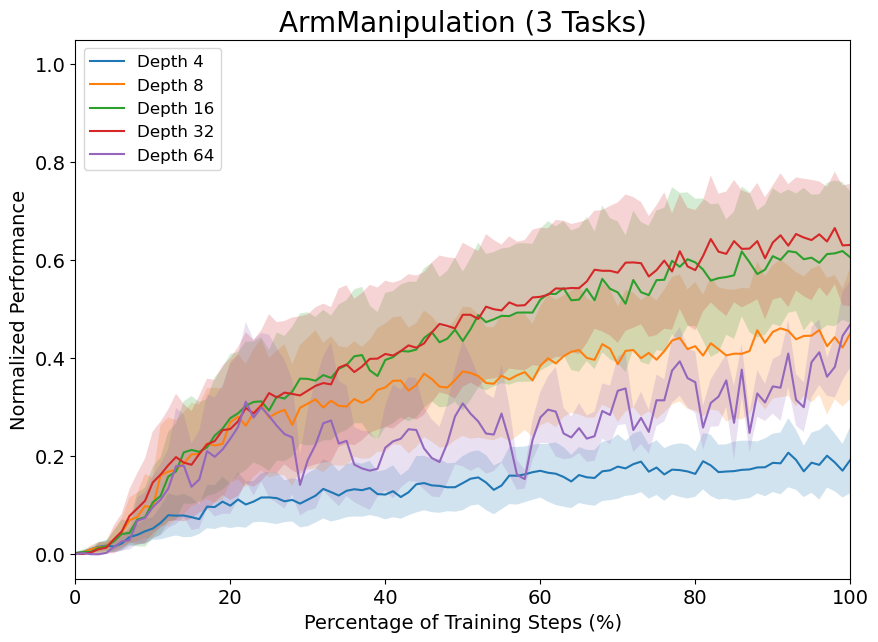

In [73]:
plt.figure(figsize=(10, 7))

for d in valid_depths:
    if d not in agg_mean:
        continue
    mean_curve = agg_mean[d]
    std_curve = agg_std[d]

    # If there's no data, skip
    if len(mean_curve) == 0:
        continue

    plt.plot(
        fractions * 100,  # Convert to percentage
        mean_curve,
        label=f"Depth {d}"
    )
    # Fill ± std
    plt.fill_between(
        fractions * 100,  # Convert to percentage
        mean_curve - 0.5 * std_curve,
        mean_curve + 0.5 * std_curve,
        alpha=0.2
    )

plt.title(f"{aggregated_title}", fontsize=20)
plt.xlabel("Percentage of Training Steps (%)", fontsize=14)  # Updated label
plt.ylabel("Normalized Performance", fontsize=14)
plt.ylim([-0.05, 1.05])
plt.xlim([0, 100])  # Set limits for percentage range
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

Env: humanoid: W&B API found 75 runs
Env: humanoid: local filters -> 28 runs remain.
Env: humanoid_u_maze: W&B API found 50 runs
Env: humanoid_u_maze: local filters -> 25 runs remain.
Env: humanoid_big_maze: W&B API found 55 runs
Env: humanoid_big_maze: local filters -> 26 runs remain.
Env: ant_big_maze: W&B API found 80 runs
Env: ant_big_maze: local filters -> 34 runs remain.
Env: ant_hardest_maze: W&B API found 79 runs
Env: ant_hardest_maze: local filters -> 28 runs remain.
Env: ant_u4_maze: W&B API found 119 runs
Env: ant_u4_maze: local filters -> 61 runs remain.
Env: ant_u5_maze: W&B API found 104 runs
Env: ant_u5_maze: local filters -> 56 runs remain.
Env: arm_push_easy: W&B API found 90 runs
Env: arm_push_easy: local filters -> 24 runs remain.
Env: arm_push_hard: W&B API found 70 runs
Env: arm_push_hard: local filters -> 26 runs remain.
Env: arm_binpick_hard: W&B API found 129 runs
Env: arm_binpick_hard: local filters -> 30 runs remain.


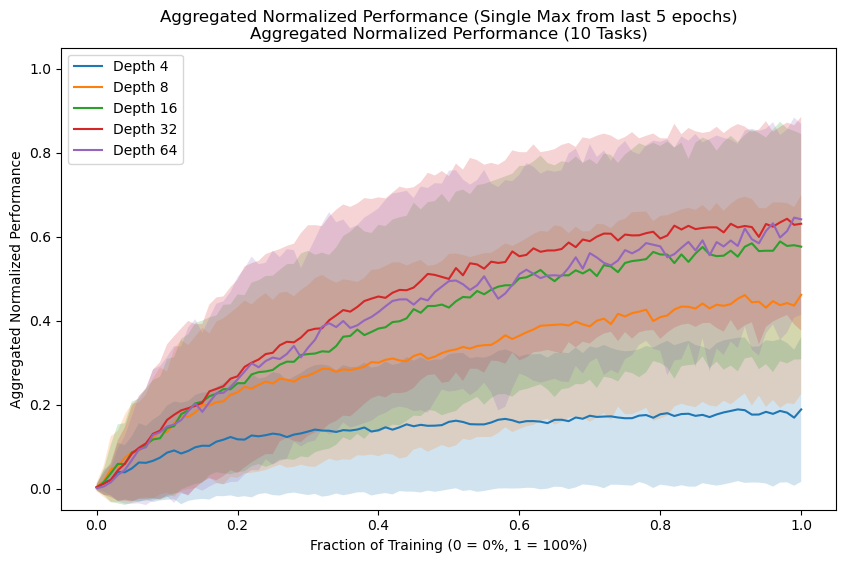

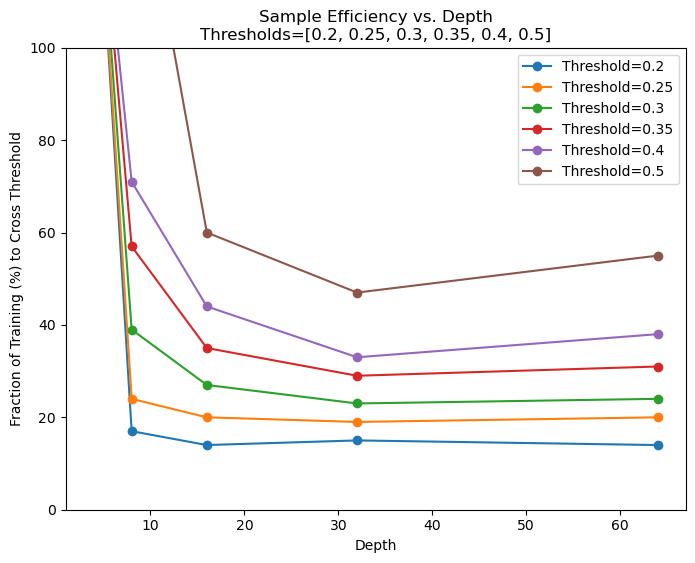

In [64]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

api = wandb.Api()

###############################################################################
# 1) Define your W&B project and environment selection
###############################################################################
entity = "wang-kevin3290-princeton-university"
project = "clean_JaxGCRL_test"

# env_type = "Humanoid"
# env_type = "AntMaze"
# env_type = "ArmManipulation"
env_type = "ALL"

if env_type == "Humanoid":
    env_ids = ["humanoid", "humanoid_u_maze", "humanoid_big_maze"]
    eval_env_ids = [None, None, None]
    num_epochss = [200, 400, 200]
    metrics = ["eval/episode_reward", "eval/episode_reward", "eval/episode_success_any"]
    aggregated_title = "Humanoid (3 Tasks)"

elif env_type == "AntMaze":
    env_ids = ["ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze"]
    eval_env_ids = ["ant_big_maze_eval", None, "ant_u4_maze_eval", None]
    num_epochss = [100, 200, 100, 200]
    metrics = ["eval/episode_success_any"] * 4
    aggregated_title = "AntMaze (4 Tasks)"

elif env_type == "ArmManipulation":
    env_ids = ["arm_push_easy", "arm_push_hard", "arm_binpick_hard"]
    eval_env_ids = [None, None, None]
    num_epochss = [100, 100, 100]
    metrics = ["eval/episode_success_hard"] * 3
    aggregated_title = "ArmManipulation (3 Tasks)"

elif env_type == "ALL":
    env_ids = [
        "humanoid", "humanoid_u_maze", "humanoid_big_maze",
        "ant_big_maze", "ant_hardest_maze", "ant_u4_maze", "ant_u5_maze",
        "arm_push_easy", "arm_push_hard", "arm_binpick_hard"
    ]
    eval_env_ids = [
        None, None, None,
        "ant_big_maze_eval", None, "ant_u4_maze_eval", None,
        None, None, None
    ]
    num_epochss = [200, 400, 200, 100, 200, 100, 200, 100, 100, 100]
    metrics = [
        "eval/episode_reward", "eval/episode_success_any", "eval/episode_success_any",
        "eval/episode_success_any", "eval/episode_success_any", "eval/episode_success_any",
        "eval/episode_success_any", "eval/episode_success_hard",
        "eval/episode_success_hard", "eval/episode_success_hard"
    ]
    aggregated_title = "Aggregated Normalized Performance (10 Tasks)"

valid_depths = [4, 8, 16, 32, 64]


###############################################################################
# 2) Gather runs from W&B and store their metric curves
###############################################################################
per_env_depth_runs = {
    env_id: {depth: [] for depth in valid_depths} for env_id in env_ids
}
env_steps = {}

for i, env_id in enumerate(env_ids):
    eval_env_id = eval_env_ids[i]
    metric = metrics[i]
    num_epochs = num_epochss[i]
    env_steps[env_id] = num_epochs

    # W&B filters
    filters = {
        "config.env_id": env_id,
        "config.num_envs": 512,
        "config.num_sgd_batches_per_training_step": 800,
        "config.critic_network_width": 256,
        "config.actor_network_width": 256,
        "config.batch_size": 512,
        "config.num_epochs": num_epochs,
        "config.eval_env_id": eval_env_id if eval_env_id else {"$in": ['', None, env_id]},
        "config.disable_entropy": {"$ne": 1},
        "config.use_relu": {"$ne": 1},
        "config.resnet": "noishmistake4_nodense",
        "config.dropout": None,
        "config.logsumexp_penalty_coeff": 0.1,
    }

    runs_api = api.runs(path=f"{entity}/{project}", filters=filters)
    print(f"Env: {env_id}: W&B API found {len(runs_api)} runs")

    # Additional local filters
    runs = []
    for run in runs_api:
        # Check if run completed fully
        if "_step" not in run.summary:
            continue
        if run.summary["_step"] != run.config["num_epochs"] - 1:
            continue
        
        actor_depth = run.config["actor_depth"]
        critic_depth = run.config["critic_depth"]
        if actor_depth != critic_depth:
            continue
        if actor_depth not in valid_depths:
            continue

        runs.append(run)
    print(f"Env: {env_id}: local filters -> {len(runs)} runs remain.")

    # Pull out the metric array
    for run in runs:
        depth = run.config["actor_depth"]
        hist = run.history()
        if metric not in hist.columns:
            continue
        values = hist[metric].values  # shape (num_epochs,)
        if len(values) != num_epochs:
            continue
        per_env_depth_runs[env_id][depth].append(values)

###############################################################################
# 3) Fraction-based interpolation: map each run to a common grid [0..1]
###############################################################################
N = 101
fractions = np.linspace(0, 1, N)  # e.g. 101 fraction points from 0% to 100%
postfix = 5  # last 5 epochs

# interpolated_runs[env_id][depth] = list of shape-(N,) curves
interpolated_runs = {
    env_id: {d: [] for d in valid_depths} for env_id in env_ids
}

for env_id in env_ids:
    num_epochs = env_steps[env_id]
    x_original = np.arange(num_epochs)  # 0..num_epochs-1
    for d in valid_depths:
        run_arrays = per_env_depth_runs[env_id][d]
        if len(run_arrays) == 0:
            continue
        for arr in run_arrays:
            interp_curve = np.interp(
                x=fractions*(num_epochs - 1),
                xp=x_original,
                fp=arr
            )
            interpolated_runs[env_id][d].append(interp_curve)

###############################################################################
# 4) For each environment, find ONE scalar = max of the last 5 epochs
#    across all runs, all depths. Then we'll normalize each fraction by this.
###############################################################################
env_global_max = {}
for env_id in env_ids:
    max_val = 0.0
    for d in valid_depths:
        run_arrays = per_env_depth_runs[env_id][d]
        for arr in run_arrays:
            last_values = arr[-postfix:]  # last 5 epochs
            run_max = np.max(last_values)
            if run_max > max_val:
                max_val = run_max
    env_global_max[env_id] = max_val

###############################################################################
# 5) Normalize the *interpolated* curves by that single environment-level max
#    from the last-5 approach, then compute within-env stats.
###############################################################################
per_env_depth_mean_curve = {}
per_env_depth_var_curve = {}

for env_id in env_ids:
    denom = env_global_max[env_id]
    if denom == 0:
        denom = 1e-10  # handle degenerate case

    for d in valid_depths:
        run_list = interpolated_runs[env_id][d]
        if len(run_list) == 0:
            continue

        # Normalize each interpolated run
        norm_runs = []
        for curve in run_list:
            norm_runs.append(curve / denom)

        run_array = np.stack(norm_runs, axis=0)  # shape (num_runs, N)

        # Mean across runs (within env+depth)
        mean_curve = np.mean(run_array, axis=0)
        # Variance across runs
        var_curve = np.mean((run_array - mean_curve) ** 2, axis=0)

        per_env_depth_mean_curve[(env_id, d)] = mean_curve
        per_env_depth_var_curve[(env_id, d)]  = var_curve

###############################################################################
# 6) Aggregate across environments (equal weighting). Use law of total variance:
#    var_agg = average(within-env vars) + average((env_mean - overall_mean)^2)
###############################################################################
agg_mean = {}
agg_std = {}

for d in valid_depths:
    mu_envs = []
    var_envs = []
    for env_id in env_ids:
        key = (env_id, d)
        if key not in per_env_depth_mean_curve:
            continue
        mu_envs.append(per_env_depth_mean_curve[key])
        var_envs.append(per_env_depth_var_curve[key])

    if len(mu_envs) == 0:
        continue

    mu_envs = np.stack(mu_envs, axis=0)   # shape (E, N)
    var_envs = np.stack(var_envs, axis=0) # shape (E, N)
    E = mu_envs.shape[0]

    mu_agg_curve = np.mean(mu_envs, axis=0)
    within_env   = np.mean(var_envs, axis=0)
    between_env  = np.mean((mu_envs - mu_agg_curve) ** 2, axis=0)
    var_agg_curve = within_env + between_env

    agg_mean[d] = mu_agg_curve
    agg_std[d]  = np.sqrt(var_agg_curve)

###############################################################################
# 7) Plot 1: Aggregated mean ± std curves for each depth
###############################################################################
plt.figure(figsize=(10, 6))

for d in valid_depths:
    if d not in agg_mean:
        continue
    mean_curve = agg_mean[d]
    std_curve  = agg_std[d]

    plt.plot(
        fractions,
        mean_curve,
        label=f"Depth {d}"
    )
    plt.fill_between(
        fractions,
        mean_curve - std_curve,
        mean_curve + std_curve,
        alpha=0.2
    )

plt.title(
    f"Aggregated Normalized Performance (Single Max from last {postfix} epochs)\n{aggregated_title}"
)
plt.xlabel("Fraction of Training (0 = 0%, 1 = 100%)")
plt.ylabel("Aggregated Normalized Performance")
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

###############################################################################
# 8) Plot 2 (OPTIONAL): If you still want a bar plot or something else,
#    you could do it here. (Omitted for brevity)
###############################################################################
# ... your original code for bar plots if needed ...

###############################################################################
# 9) Plot 3: Threshold crossing vs. Depth (sample efficiency).
#
#    For each threshold T, find the fraction of training at which each
#    depth's aggregated curve (agg_mean[d]) first crosses T.
###############################################################################

# You can specify multiple thresholds here:
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]  # for example, or any list you like

# We'll store threshold_crossings[T][d] = fraction in [0..1]
# If not crossed, we store some large # like 1.2 (120%)
threshold_crossings = {
    T: {d: 1.5 for d in valid_depths}  # default = 120% (off the chart)
    for T in thresholds
}

for T in thresholds:
    for d in valid_depths:
        if d not in agg_mean:
            continue
        curve = agg_mean[d]  # shape (N,), aggregated mean
        # find the first fraction index i where curve[i] >= T
        idx = np.where(curve >= T)[0]
        if len(idx) > 0:
            i_found = idx[0]
            threshold_crossings[T][d] = fractions[i_found]  # fraction in [0..1]

# Now we make a single plot with multiple lines: x=depth, y= fraction*100
plt.figure(figsize=(8, 6))
for T in thresholds:
    # gather y-values in the order of valid_depths
    y_vals = []
    for d in valid_depths:
        frac_val = threshold_crossings[T][d]
        y_vals.append(frac_val * 100.0)  # convert fraction -> % of training

    # plot them (line or scatter)
    plt.plot(
        valid_depths, 
        y_vals, 
        marker='o',
        label=f"Threshold={T}"
    )

# limit y-axis to [0..100], so anything above 100 is off chart
plt.ylim(0, 100)
plt.xlabel("Depth")
plt.ylabel("Fraction of Training (%) to Cross Threshold")
plt.title(f"Sample Efficiency vs. Depth\nThresholds={thresholds}")
plt.legend()
plt.show()


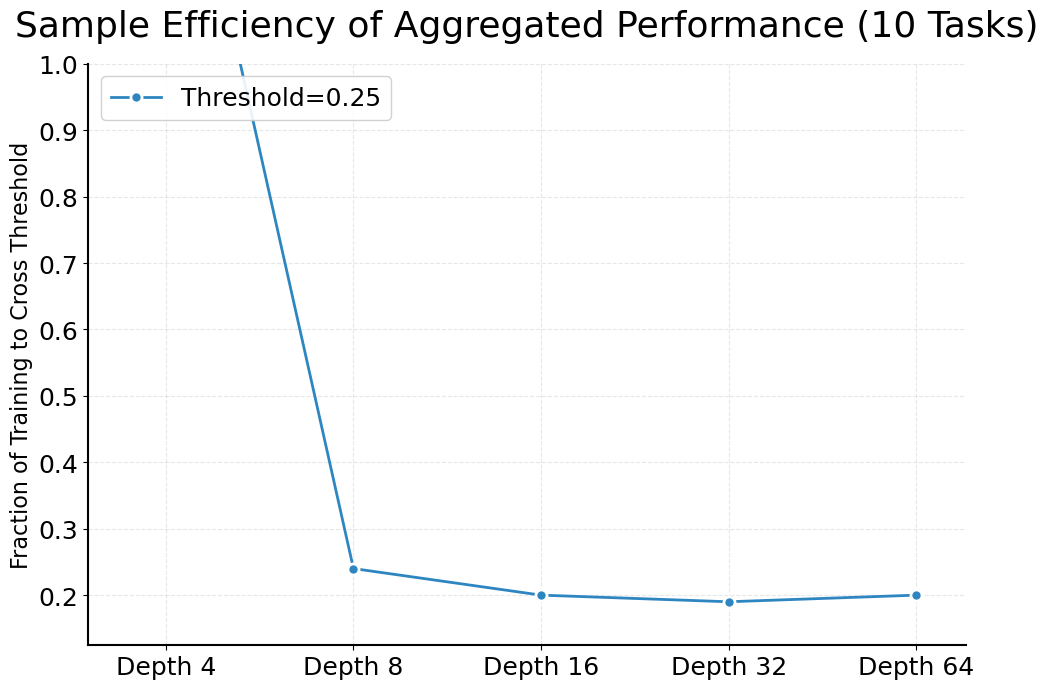

In [66]:
thresholds = [0.25]
plt.figure(figsize=(10, 7))  # Larger figure with better aspect ratio

for T in thresholds:
    # gather y-values in the order of valid_depths
    y_vals = []
    for d in valid_depths:
        frac_val = threshold_crossings[T][d]
        y_vals.append(frac_val)  # Keep as fraction instead of percentage

    # Enhanced plot styling
    plt.plot(
        valid_depths, 
        y_vals, 
        marker='o',
        label=f"Threshold={T}",
        color='#2E86C1',  # Nice blue color
        markersize=8,  # Larger markers
        markeredgewidth=2,  # Thicker marker edges
        markeredgecolor='white',  # White edge around markers
        linewidth=2,  # Thicker line
    )

# Customize grid and axes
plt.grid(True, linestyle='--', alpha=0.3)
plt.xscale('log', base=2)
plt.ylim(top=1.0)  # Changed from percentage to fraction
plt.xlim([min(valid_depths) - 1, max(valid_depths) * 1.2])

# Customize spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Labels and ticks
plt.ylabel("Fraction of Training to Cross Threshold", fontsize=16)
plt.title(f"Sample Efficiency of {aggregated_title}", fontsize=26, pad=20)
plt.yticks(fontsize=18)
plt.xticks(valid_depths, [f"Depth {d}" for d in valid_depths], fontsize=18)
plt.legend(fontsize=18, loc='upper left', framealpha=0.9)

# Add some padding
plt.tight_layout()
plt.show()